In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from prophet import Prophet

# Paths

NOTEBOOK_DIR = Path.cwd().resolve()
PROJECT_ROOT = NOTEBOOK_DIR.parent

DATA_PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
FIGURES_DIR = PROJECT_ROOT / "reports" / "figures"
PROPHET_FIGURES_DIR = FIGURES_DIR / "prophet_forecasts"

PROPHET_FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print("Project root       :", PROJECT_ROOT)
print("Data processed dir :", DATA_PROCESSED_DIR)
print("Figures dir        :", FIGURES_DIR)
print("Prophet figures dir:", PROPHET_FIGURES_DIR)

Project root       : D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data
Data processed dir : D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\data\processed
Figures dir        : D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures
Prophet figures dir: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts


In [2]:
# Load train and test splits

train_path = DATA_PROCESSED_DIR / "panel_country_split_train.csv"
test_path  = DATA_PROCESSED_DIR / "panel_country_split_test.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

# Combine into a single panel (all countries, all years)

panel_df = pd.concat([train_df, test_df], ignore_index=True)

# Just to be safe, drop duplicates if any
panel_df = panel_df.drop_duplicates(subset=["Country", "Year"])

print("Combined panel shape:", panel_df.shape)
panel_df.head()

Train shape: (9917, 6)
Test  shape: (2532, 6)
Combined panel shape: (12449, 6)


,Country,Year,fertility,migration,urban_pop,flfp
0,Afghanistan,2006,6.686,57673.0,22.907,41.241034
1,Afghanistan,1974,7.526,-20009.0,13.219,6.830000
2,Afghanistan,1981,7.617,-1998086.0,16.562,9.378966
3,Afghanistan,1993,7.761,1149684.0,21.444,24.672759
4,Afghanistan,1991,7.631,32782.0,21.266,22.123793


In [3]:
# Prophet settings

TARGET_COL = "fertility"
COUNTRY_COL = "Country"
YEAR_COL = "Year"

FORECAST_HORIZON = 10  # forecast 10 years into the future

countries = sorted(panel_df[COUNTRY_COL].unique())
print("Number of countries:", len(countries))
print("Example countries:", countries[:10])

Number of countries: 211
Example countries: ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Australia']


In [4]:
def prepare_country_timeseries(df, country_name):
    """
    Filter panel df for a single country and prepare it
    for Prophet (columns: ds, y).
    """
    country_df = df[df[COUNTRY_COL] == country_name].copy()
    country_df = country_df.sort_values(by=YEAR_COL)
    
    # Keep only Year and fertility
    ts_df = country_df[[YEAR_COL, TARGET_COL]].rename(
        columns={
            YEAR_COL: "ds",
            TARGET_COL: "y"
        }
    )
    
    # Convert year (int) to datetime (yearly)
    ts_df["ds"] = pd.to_datetime(ts_df["ds"].astype(int), format="%Y")
    
    return ts_df


def fit_and_forecast_prophet(ts_df, horizon_years=10):
    """
    Fit a Prophet model on a given time series and forecast
    for 'horizon_years' into the future (annual frequency).
    """
    # Disable daily/weekly seasonality; yearly is optional with annual data
    model = Prophet(
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    model.fit(ts_df)
    
    future = model.make_future_dataframe(
        periods=horizon_years,
        freq="Y"  # yearly frequency
    )
    
    forecast = model.predict(future)
    return model, forecast

In [5]:
all_forecasts = []

for country in countries:
    print(f"\n=== Processing country: {country} ===")
    
    ts_df = prepare_country_timeseries(panel_df, country)
    
    # If not enough data points, skip
    if ts_df["ds"].nunique() < 3:
        print(f"Skipping {country}: not enough data points ({len(ts_df)})")
        continue
    
    # Fit model and forecast
    model, forecast = fit_and_forecast_prophet(
        ts_df,
        horizon_years=FORECAST_HORIZON
    )
    
    # Add country column to forecast
    forecast["Country"] = country
    
    # Keep only useful columns
    forecast_subset = forecast[["Country", "ds", "yhat", "yhat_lower", "yhat_upper"]]
    all_forecasts.append(forecast_subset)
    
    fig = model.plot(forecast)
    plt.title(f"Fertility Forecast - {country}")

    import matplotlib.dates as mdates
    ax = fig.gca()
    ax.xaxis.set_major_locator(mdates.YearLocator(base=10))   # her 10 yılda bir tick
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # × sadece yılı göster
    fig.autofmt_xdate()

    fig_path = PROPHET_FIGURES_DIR / f"prophet_forecast_{country}.png"
    fig.savefig(fig_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

    print(f"Saved forecast plot to: {fig_path}")

# Combine all forecasts into a single DataFrame

if all_forecasts:
    forecasts_df = pd.concat(all_forecasts, ignore_index=True)
    print("\nCombined forecast shape:", forecasts_df.shape)
else:
    forecasts_df = pd.DataFrame()
    print("\nNo forecasts produced.")


=== Processing country: Afghanistan ===


18:24:22 - cmdstanpy - INFO - Chain [1] start processing
18:24:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:23 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Afghanistan.png

=== Processing country: Albania ===


18:24:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Albania.png

=== Processing country: Algeria ===


18:24:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:25 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Algeria.png

=== Processing country: Andorra ===


18:24:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:25 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Andorra.png

=== Processing country: Angola ===


18:24:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Angola.png

=== Processing country: Antigua and Barbuda ===


18:24:27 - cmdstanpy - INFO - Chain [1] start processing
18:24:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Antigua and Barbuda.png

=== Processing country: Argentina ===


18:24:30 - cmdstanpy - INFO - Chain [1] start processing
18:24:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Argentina.png

=== Processing country: Armenia ===


18:24:33 - cmdstanpy - INFO - Chain [1] start processing
18:24:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Armenia.png

=== Processing country: Aruba ===


18:24:35 - cmdstanpy - INFO - Chain [1] start processing
18:24:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Aruba.png

=== Processing country: Australia ===


18:24:38 - cmdstanpy - INFO - Chain [1] start processing
18:24:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Australia.png

=== Processing country: Austria ===


18:24:40 - cmdstanpy - INFO - Chain [1] start processing
18:24:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:43 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Austria.png

=== Processing country: Azerbaijan ===


18:24:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Azerbaijan.png

=== Processing country: Bahamas ===


18:24:45 - cmdstanpy - INFO - Chain [1] start processing
18:24:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bahamas.png

=== Processing country: Bahrain ===


18:24:48 - cmdstanpy - INFO - Chain [1] start processing
18:24:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:50 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bahrain.png

=== Processing country: Bangladesh ===


18:24:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:51 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bangladesh.png

=== Processing country: Barbados ===


18:24:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:52 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Barbados.png

=== Processing country: Belarus ===


18:24:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:53 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Belarus.png

=== Processing country: Belgium ===


18:24:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:54 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Belgium.png

=== Processing country: Belize ===


18:24:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:55 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Belize.png

=== Processing country: Benin ===


18:24:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:55 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Benin.png

=== Processing country: Bermuda ===


18:24:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:56 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bermuda.png

=== Processing country: Bhutan ===


18:24:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:57 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bhutan.png

=== Processing country: Bolivia (Plurinational State of) ===


18:24:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:58 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bolivia (Plurinational State of).png

=== Processing country: Bosnia and Herzegovina ===


18:24:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:24:59 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bosnia and Herzegovina.png

=== Processing country: Botswana ===


18:25:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:00 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Botswana.png

=== Processing country: Brazil ===


18:25:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:01 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Brazil.png

=== Processing country: British Virgin Islands ===


18:25:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:02 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_British Virgin Islands.png

=== Processing country: Brunei ===


18:25:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:03 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Brunei.png

=== Processing country: Bulgaria ===


18:25:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:04 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Bulgaria.png

=== Processing country: Burkina Faso ===


18:25:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:04 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Burkina Faso.png

=== Processing country: Burundi ===


18:25:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:05 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Burundi.png

=== Processing country: Cabo Verde ===


18:25:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:06 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cabo Verde.png

=== Processing country: Cambodia ===


18:25:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:07 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cambodia.png

=== Processing country: Cameroon ===


18:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:08 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cameroon.png

=== Processing country: Canada ===


18:25:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:09 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Canada.png

=== Processing country: Cayman Islands ===


18:25:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:10 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cayman Islands.png

=== Processing country: Chad ===


18:25:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:11 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Chad.png

=== Processing country: Channel Islands ===


18:25:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:12 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Channel Islands.png

=== Processing country: Chile ===


18:25:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:13 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Chile.png

=== Processing country: China ===


18:25:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:13 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_China.png

=== Processing country: Colombia ===


18:25:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:15 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Colombia.png

=== Processing country: Comoros ===


18:25:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:16 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Comoros.png

=== Processing country: Congo ===


18:25:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:17 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Congo.png

=== Processing country: Congo (Democratic Republic of the) ===


18:25:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:18 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Congo (Democratic Republic of the).png

=== Processing country: Costa Rica ===


18:25:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:18 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Costa Rica.png

=== Processing country: Croatia ===


18:25:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:19 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Croatia.png

=== Processing country: Cuba ===


18:25:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:20 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cuba.png

=== Processing country: Curaçao ===


18:25:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:21 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Curaçao.png

=== Processing country: Cyprus ===


18:25:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:22 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Cyprus.png

=== Processing country: Czechia ===


18:25:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:23 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Czechia.png

=== Processing country: Côte d’Ivoire ===


18:25:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Côte d’Ivoire.png

=== Processing country: Denmark ===


18:25:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Denmark.png

=== Processing country: Djibouti ===


18:25:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:25 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Djibouti.png

=== Processing country: Dominica ===


18:25:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:26 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Dominica.png

=== Processing country: Dominican Republic ===


18:25:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:27 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Dominican Republic.png

=== Processing country: Ecuador ===


18:25:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:28 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Ecuador.png

=== Processing country: Egypt ===


18:25:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:29 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Egypt.png

=== Processing country: El Salvador ===


18:25:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:30 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_El Salvador.png

=== Processing country: Equatorial Guinea ===


18:25:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:31 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Equatorial Guinea.png

=== Processing country: Eritrea ===


18:25:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:32 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Eritrea.png

=== Processing country: Estonia ===


18:25:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:33 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Estonia.png

=== Processing country: Eswatini ===


18:25:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:34 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Eswatini.png

=== Processing country: Ethiopia ===


18:25:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:35 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Ethiopia.png

=== Processing country: Faroe Islands ===


18:25:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:35 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Faroe Islands.png

=== Processing country: Fiji ===


18:25:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:36 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Fiji.png

=== Processing country: Finland ===


18:25:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:37 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Finland.png

=== Processing country: France ===


18:25:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:38 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_France.png

=== Processing country: French Polynesia ===


18:25:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:39 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_French Polynesia.png

=== Processing country: Gabon ===


18:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:40 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Gabon.png

=== Processing country: Gambia ===


18:25:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:41 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Gambia.png

=== Processing country: Georgia ===


18:25:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:42 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Georgia.png

=== Processing country: Germany ===


18:25:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:43 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Germany.png

=== Processing country: Ghana ===


18:25:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:43 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Ghana.png

=== Processing country: Gibraltar ===


18:25:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:44 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Gibraltar.png

=== Processing country: Greece ===


18:25:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:45 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Greece.png

=== Processing country: Greenland ===


18:25:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:46 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Greenland.png

=== Processing country: Grenada ===


18:25:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:47 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Grenada.png

=== Processing country: Guam ===


18:25:47 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:48 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Guam.png

=== Processing country: Guatemala ===


18:25:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:49 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Guatemala.png

=== Processing country: Guinea ===


18:25:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:49 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Guinea.png

=== Processing country: Guinea-Bissau ===


18:25:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:50 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Guinea-Bissau.png

=== Processing country: Guyana ===


18:25:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:52 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Guyana.png

=== Processing country: Haiti ===


18:25:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:53 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Haiti.png

=== Processing country: Honduras ===


18:25:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:53 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Honduras.png

=== Processing country: Hong Kong SAR, China ===


18:25:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:54 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Hong Kong SAR, China.png

=== Processing country: Hungary ===


18:25:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:55 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Hungary.png

=== Processing country: Iceland ===


18:25:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:56 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Iceland.png

=== Processing country: India ===


18:25:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:57 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_India.png

=== Processing country: Indonesia ===


18:25:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:58 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Indonesia.png

=== Processing country: Iran ===


18:25:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:59 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Iran.png

=== Processing country: Iraq ===


18:25:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:25:59 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Iraq.png

=== Processing country: Ireland ===


18:26:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:00 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Ireland.png

=== Processing country: Isle of Man ===


18:26:01 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:01 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Isle of Man.png

=== Processing country: Israel ===


18:26:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:02 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Israel.png

=== Processing country: Italy ===


18:26:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:03 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Italy.png

=== Processing country: Jamaica ===


18:26:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:04 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Jamaica.png

=== Processing country: Japan ===


18:26:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:05 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Japan.png

=== Processing country: Jordan ===


18:26:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:06 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Jordan.png

=== Processing country: Kazakhstan ===


18:26:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:07 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Kazakhstan.png

=== Processing country: Kenya ===


18:26:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:07 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Kenya.png

=== Processing country: Kiribati ===


18:26:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:08 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Kiribati.png

=== Processing country: Korea, Democratic People’s Republic of ===


18:26:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:09 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Korea, Democratic People’s Republic of.png

=== Processing country: Korea, Republic of ===


18:26:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:10 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Korea, Republic of.png

=== Processing country: Kuwait ===


18:26:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:11 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Kuwait.png

=== Processing country: Kyrgyzstan ===


18:26:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:12 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Kyrgyzstan.png

=== Processing country: Laos ===


18:26:12 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:13 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Laos.png

=== Processing country: Latvia ===


18:26:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:14 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Latvia.png

=== Processing country: Lebanon ===


18:26:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:15 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Lebanon.png

=== Processing country: Lesotho ===


18:26:15 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:16 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Lesotho.png

=== Processing country: Liberia ===


18:26:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:17 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Liberia.png

=== Processing country: Libya ===


18:26:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:18 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Libya.png

=== Processing country: Liechtenstein ===


18:26:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:18 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Liechtenstein.png

=== Processing country: Lithuania ===


18:26:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:19 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Lithuania.png

=== Processing country: Luxembourg ===


18:26:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:20 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Luxembourg.png

=== Processing country: Macao SAR, China ===


18:26:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:21 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Macao SAR, China.png

=== Processing country: Madagascar ===


18:26:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:22 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Madagascar.png

=== Processing country: Malawi ===


18:26:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:23 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Malawi.png

=== Processing country: Malaysia ===


18:26:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Malaysia.png

=== Processing country: Maldives ===


18:26:24 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:25 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Maldives.png

=== Processing country: Mali ===


18:26:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:26 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mali.png

=== Processing country: Malta ===


18:26:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:26 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Malta.png

=== Processing country: Marshall Islands ===


18:26:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:27 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Marshall Islands.png

=== Processing country: Mauritania ===


18:26:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:29 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mauritania.png

=== Processing country: Mauritius ===


18:26:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:29 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mauritius.png

=== Processing country: Mexico ===


18:26:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:30 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mexico.png

=== Processing country: Micronesia, Federated States of ===


18:26:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:31 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Micronesia, Federated States of.png

=== Processing country: Moldova ===


18:26:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:32 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Moldova.png

=== Processing country: Monaco ===


18:26:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:33 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Monaco.png

=== Processing country: Mongolia ===


18:26:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:34 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mongolia.png

=== Processing country: Montenegro ===


18:26:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:36 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Montenegro.png

=== Processing country: Morocco ===


18:26:37 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:37 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Morocco.png

=== Processing country: Mozambique ===


18:26:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Mozambique.png

=== Processing country: Myanmar ===


18:26:40 - cmdstanpy - INFO - Chain [1] start processing
18:26:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:41 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Myanmar.png

=== Processing country: Namibia ===


18:26:42 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:43 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Namibia.png

=== Processing country: Nauru ===


18:26:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:45 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Nauru.png

=== Processing country: Nepal ===


18:26:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:47 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Nepal.png

=== Processing country: Netherlands ===


18:26:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Netherlands.png

=== Processing country: New Caledonia ===


18:26:49 - cmdstanpy - INFO - Chain [1] start processing
18:26:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:51 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_New Caledonia.png

=== Processing country: New Zealand ===


18:26:51 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_New Zealand.png

=== Processing country: Nicaragua ===


18:26:52 - cmdstanpy - INFO - Chain [1] start processing
18:26:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:54 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Nicaragua.png

=== Processing country: Niger ===


18:26:54 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:55 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Niger.png

=== Processing country: Nigeria ===


18:26:56 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:57 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Nigeria.png

=== Processing country: North Macedonia ===


18:26:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:26:58 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_North Macedonia.png

=== Processing country: Northern Mariana Islands ===


18:26:59 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:00 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Northern Mariana Islands.png

=== Processing country: Norway ===


18:27:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:01 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Norway.png

=== Processing country: Oman ===


18:27:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:03 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Oman.png

=== Processing country: Pakistan ===


18:27:04 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:05 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Pakistan.png

=== Processing country: Palau ===


18:27:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:07 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Palau.png

=== Processing country: Palestine ===


18:27:07 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:08 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Palestine.png

=== Processing country: Panama ===


18:27:09 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:10 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Panama.png

=== Processing country: Papua New Guinea ===


18:27:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Papua New Guinea.png

=== Processing country: Paraguay ===


18:27:12 - cmdstanpy - INFO - Chain [1] start processing
18:27:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:14 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Paraguay.png

=== Processing country: Peru ===


18:27:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:15 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Peru.png

=== Processing country: Philippines ===


18:27:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:17 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Philippines.png

=== Processing country: Poland ===


18:27:17 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:18 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Poland.png

=== Processing country: Portugal ===


18:27:19 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:20 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Portugal.png

=== Processing country: Puerto Rico ===


18:27:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:21 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Puerto Rico.png

=== Processing country: Qatar ===


18:27:22 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:23 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Qatar.png

=== Processing country: Romania ===


18:27:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Romania.png

=== Processing country: Russia ===


18:27:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Russia.png

=== Processing country: Rwanda ===


18:27:26 - cmdstanpy - INFO - Chain [1] start processing
18:27:26 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:27 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Rwanda.png

=== Processing country: Samoa ===


18:27:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:29 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Samoa.png

=== Processing country: San Marino ===


18:27:29 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:30 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_San Marino.png

=== Processing country: Sao Tome and Principe ===


18:27:31 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:32 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sao Tome and Principe.png

=== Processing country: Saudi Arabia ===


18:27:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:34 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Saudi Arabia.png

=== Processing country: Senegal ===


18:27:34 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:35 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Senegal.png

=== Processing country: Serbia ===


18:27:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:37 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Serbia.png

=== Processing country: Seychelles ===


18:27:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:39 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Seychelles.png

=== Processing country: Sierra Leone ===


18:27:39 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:40 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sierra Leone.png

=== Processing country: Singapore ===


18:27:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:42 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Singapore.png

=== Processing country: Sint Maarten (Dutch part) ===


18:27:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:44 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sint Maarten (Dutch part).png

=== Processing country: Slovakia ===


18:27:44 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:45 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Slovakia.png

=== Processing country: Slovenia ===


18:27:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:47 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Slovenia.png

=== Processing country: Solomon Islands ===


18:27:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:49 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Solomon Islands.png

=== Processing country: Somalia ===


18:27:49 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:51 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Somalia.png

=== Processing country: South Sudan ===


18:27:52 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:53 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_South Sudan.png

=== Processing country: Spain ===


18:27:53 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:54 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Spain.png

=== Processing country: Sri Lanka ===


18:27:55 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:56 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sri Lanka.png

=== Processing country: St. Kitts and Nevis ===


18:27:57 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:58 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_St. Kitts and Nevis.png

=== Processing country: St. Lucia ===


18:27:58 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:27:59 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_St. Lucia.png

=== Processing country: St. Vincent and the Grenadines ===


18:28:00 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:01 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_St. Vincent and the Grenadines.png

=== Processing country: Sudan ===


18:28:02 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:03 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sudan.png

=== Processing country: Suriname ===


18:28:03 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:04 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Suriname.png

=== Processing country: Sweden ===


18:28:05 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:06 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Sweden.png

=== Processing country: Switzerland ===


18:28:06 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:07 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Switzerland.png

=== Processing country: Syria ===


18:28:08 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:09 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Syria.png

=== Processing country: Tajikistan ===


18:28:10 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:11 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Tajikistan.png

=== Processing country: Tanzania, United Republic of ===


18:28:11 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:12 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Tanzania, United Republic of.png

=== Processing country: Thailand ===


18:28:13 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:14 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Thailand.png

=== Processing country: Timor-Leste ===


18:28:14 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:15 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Timor-Leste.png

=== Processing country: Togo ===


18:28:16 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:17 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Togo.png

=== Processing country: Tonga ===


18:28:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:19 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Tonga.png

=== Processing country: Trinidad and Tobago ===


18:28:20 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:21 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Trinidad and Tobago.png

=== Processing country: Tunisia ===


18:28:21 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:22 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Tunisia.png

=== Processing country: Turkey ===


18:28:23 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:24 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Turkey.png

=== Processing country: Turkmenistan ===


18:28:25 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:26 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Turkmenistan.png

=== Processing country: Turks and Caicos Islands ===


18:28:27 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:28 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Turks and Caicos Islands.png

=== Processing country: Tuvalu ===


18:28:28 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:29 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Tuvalu.png

=== Processing country: Uganda ===


18:28:30 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:31 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Uganda.png

=== Processing country: Ukraine ===


18:28:32 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:33 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Ukraine.png

=== Processing country: United Arab Emirates ===


18:28:33 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:34 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_United Arab Emirates.png

=== Processing country: United Kingdom ===


18:28:35 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:36 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_United Kingdom.png

=== Processing country: United States Virgin Islands ===


18:28:36 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:37 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_United States Virgin Islands.png

=== Processing country: Uruguay ===


18:28:38 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:38 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Uruguay.png

=== Processing country: Uzbekistan ===


18:28:40 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:41 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Uzbekistan.png

=== Processing country: Vanuatu ===


18:28:41 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:42 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Vanuatu.png

=== Processing country: Venezuela (Bolivarian Republic of) ===


18:28:43 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Venezuela (Bolivarian Republic of).png

=== Processing country: Vietnam ===


18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:46 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Vietnam.png

=== Processing country: Yemen ===


18:28:46 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:48 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Yemen.png

=== Processing country: Zambia ===


18:28:48 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(
18:28:49 - cmdstanpy - INFO - Chain [1] start processing


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Zambia.png

=== Processing country: Zimbabwe ===


18:28:50 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\berke\AppData\Local\Programs\Python\Python313\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


Saved forecast plot to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\prophet_forecast_Zimbabwe.png

Combined forecast shape: (14559, 5)


In [6]:
# Global Fertility Time Series

# Compute global (unweighted) yearly mean fertility
global_df = panel_df.groupby("Year")["fertility"].mean().reset_index()

print("Global TS Shape:", global_df.shape)
global_df.head()

Global TS Shape: (59, 2)


,Year,fertility
0,1960,5.415521
1,1961,5.399910
2,1962,5.407773
3,1963,5.406597
4,1964,5.374431


In [7]:
# Prepare for Prophet (rename + convert to datetime)
global_ts = global_df.rename(columns={
    "Year": "ds",
    "fertility": "y"
})

global_ts["ds"] = pd.to_datetime(global_ts["ds"].astype(int), format="%Y")

global_ts.head()

,ds,y
0,1960-01-01,5.415521
1,1961-01-01,5.399910
2,1962-01-01,5.407773
3,1963-01-01,5.406597
4,1964-01-01,5.374431


In [8]:
from prophet import Prophet

global_model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

global_model.fit(global_ts)

print("Global Prophet model fitted.")

18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing


Global Prophet model fitted.


In [9]:
GLOBAL_HORIZON = 10

global_future = global_model.make_future_dataframe(
    periods=GLOBAL_HORIZON,
    freq="YE"
)

global_forecast = global_model.predict(global_future)

global_forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail(10)

,ds,yhat,yhat_lower,yhat_upper
59,2018-12-31,2.588396,2.572816,2.604158
60,2019-12-31,2.559065,2.539773,2.578424
61,2020-12-31,2.529653,2.506919,2.554824
62,2021-12-31,2.500322,2.469638,2.535901
63,2022-12-31,2.470990,2.429503,2.516938
64,2023-12-31,2.441659,2.384470,2.504065
65,2024-12-31,2.412248,2.335734,2.494278
66,2025-12-31,2.382916,2.285286,2.482308
67,2026-12-31,2.353585,2.248007,2.473915
68,2027-12-31,2.324254,2.190599,2.464255


Saved Global Forecast Figure to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\reports\figures\prophet_forecasts\global_fertility_forecast.png


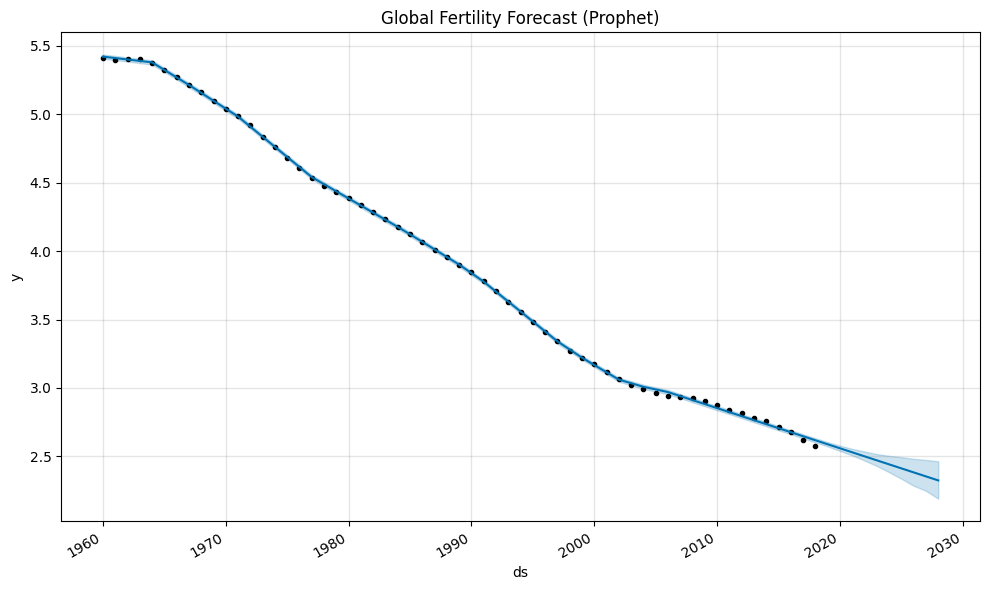

In [10]:
fig = global_model.plot(global_forecast)
plt.title("Global Fertility Forecast (Prophet)")

import matplotlib.dates as mdates
ax = fig.gca()
ax.xaxis.set_major_locator(mdates.YearLocator(base=10))   # 1960, 1970, 1980...
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))  # Etiket: sadece yıl
fig.autofmt_xdate()
plt.tight_layout()

global_fig_path = PROPHET_FIGURES_DIR / "global_fertility_forecast.png"
fig.savefig(global_fig_path, dpi=300, bbox_inches="tight")

print("Saved Global Forecast Figure to:", global_fig_path)
plt.show()

In [11]:
global_csv_path = DATA_PROCESSED_DIR / "prophet_global_forecast.csv"
global_forecast.to_csv(global_csv_path, index=False)

print("Global Forecast Saved to:", global_csv_path)

Global Forecast Saved to: D:\DS-Project\Demographic-Change_Understanding-Fertility-Through-Data\data\processed\prophet_global_forecast.csv
